# fusion_analysis_d23a
BSG, 2023

In [1]:
import d23a
import datetime
import matplotlib.pyplot as plt

In [2]:
# Get start datetime
start_dt = datetime.datetime.now()

## Figures for manuscript

Written o01.pdf (0.01 MB)
Written o01.png (0.04 MB)
Written o02.pdf (0.01 MB)
Written o02.png (0.03 MB)
Written o03.pdf (0.01 MB)
Written o03.png (0.02 MB)


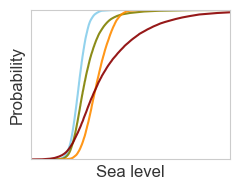

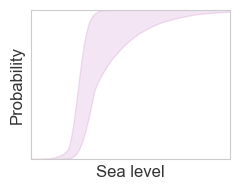

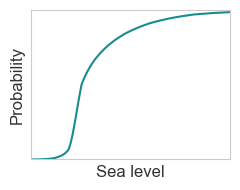

In [3]:
# Panels for schematic figure
for workflows, pbox in ([('wf_1e', 'wf_2e', 'wf_3e', 'wf_4'), False],
                        [(list()), True],
                        [('fusion_1e+2e',), False]):
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
    # Plot data
    ax = d23a.plot_sl_qfs(workflows=workflows, bg_workflows=list(), pbox=pbox,
                          rate=False, scenario='ssp585', year=2100, gauge=None, ax=ax)
    # Simplify plot by removing legend etc
    ax.set_xlim((0., 3.))
    ax.get_legend().remove()
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.grid(False)
    ax.set_xlabel('Sea level', fontweight='regular', color='0.2')
    ax.set_ylabel('Probability', fontweight='regular', color='0.2')
    for pos in ax.spines:
        ax.spines[pos].set_color('0.8')
    plt.tight_layout()
    # Save as other figure
    d23a.name_save_fig(fig, fso='o')
# Increase main figure counter
_ = next(d23a.F_NUM)

Written fig02.pdf (0.05 MB)
Written fig02.png (0.63 MB)


'fig02'

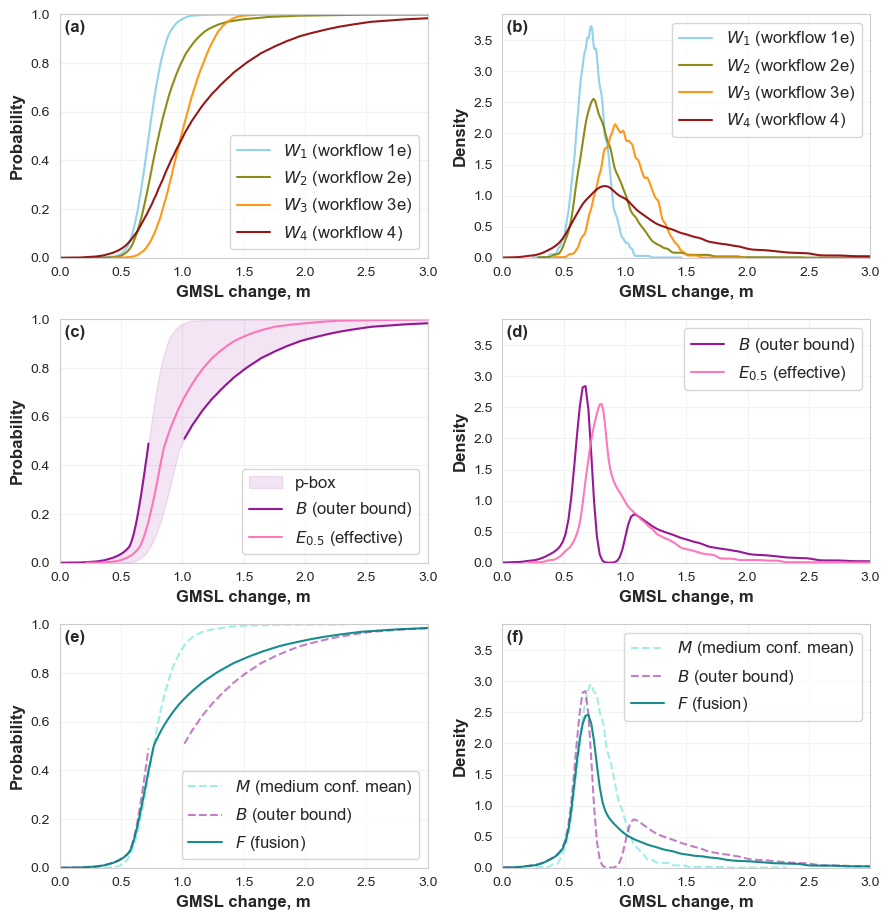

In [4]:
# SSP5 year-2100 AR6 projections, p-box, and fusion
fig, axs = d23a.fig_qfs_marginals(workflows_r=(('wf_1e', 'wf_2e', 'wf_3e', 'wf_4'), ('outer', 'effective_0.5'), ('fusion_1e+2e',)),
                                  bg_workflows_r=(list(), list(), ('mean_1e+2e', 'outer')),
                                  pbox_r=(False, True, False),
                                  rate=False, scenario='ssp585', year=2100, gauge=None, xlim=(0., 3.))
d23a.name_save_fig(fig)

Written fig03.pdf (0.02 MB)
Written fig03.png (0.09 MB)


'fig03'

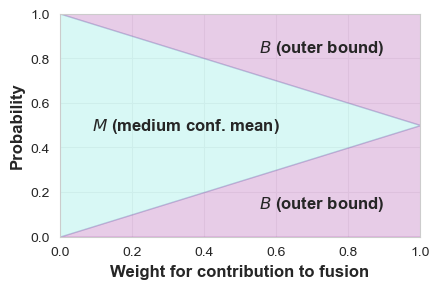

In [5]:
# Weighting function
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), tight_layout=True)
ax = d23a.plot_fusion_weights(ax=ax)
d23a.name_save_fig(fig)

Written fig04.pdf (0.03 MB)
Written fig04.png (0.13 MB)


'fig04'

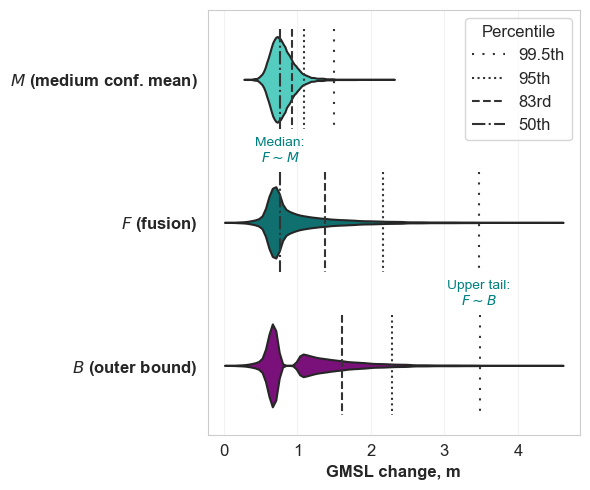

In [6]:
# SSP5 year-2100 violinplot
fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)
ax = d23a.plot_sl_violinplot(workflows=('mean_1e+2e', 'fusion_1e+2e', 'outer'),
                             rate=False, scenario='ssp585', year=2100, gauge=None, annotations=True, ax=ax)
d23a.name_save_fig(fig)

Written fig05.pdf (0.03 MB)
Written fig05.png (0.13 MB)


'fig05'

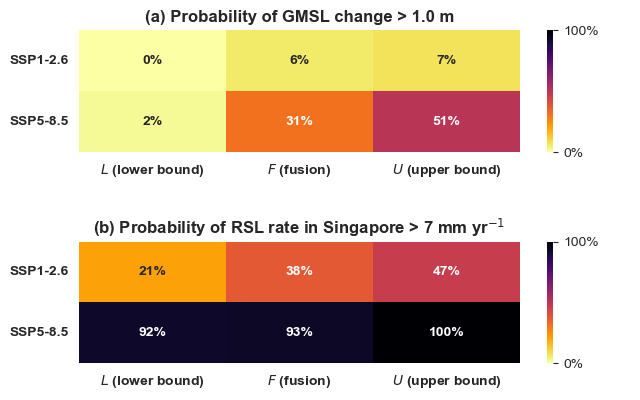

In [7]:
# SSP5 vs SSP1 heatmap tables for probability of exceeding (a) 0.86 m and (b) 7 mm/yr
fig, axs = plt.subplots(3, 1, height_ratios=[2, 0.1, 2], figsize=(6.5, 4.1), tight_layout=True)
# (a) 1.5 m
ax = axs[0]
threshold = 1.0
_ = d23a.plot_exceedance_heatmap(threshold=threshold, workflows=('lower', 'fusion_1e+2e', 'upper'), rate=False,
                                 scenarios=('ssp126', 'ssp585'), year=2100, gauge=None, ax=ax)
ax.set_title(f'(a) Probability of GMSL change > {threshold:.1f} m')
# Empty plot to create space (following issues with subplot_adjust, pad etc)
axs[1].axis('off')
# (b) 7 mm/yr
ax = axs[2]
threshold = 7
_ = d23a.plot_exceedance_heatmap(threshold=threshold, workflows=('lower', 'fusion_1f+2f', 'upper'), rate=True,
                                 scenarios=('ssp126', 'ssp585'), year=2100, gauge='TANJONG_PAGAR', ax=ax)
ax.set_title(f'(b) Probability of RSL rate in Singapore > {threshold:.0f} ' + 'mm yr$^{-1}$')
# Save
d23a.name_save_fig(fig)

## Supplementary figures

Written s01.pdf (0.05 MB)
Written s01.png (0.64 MB)


's01'

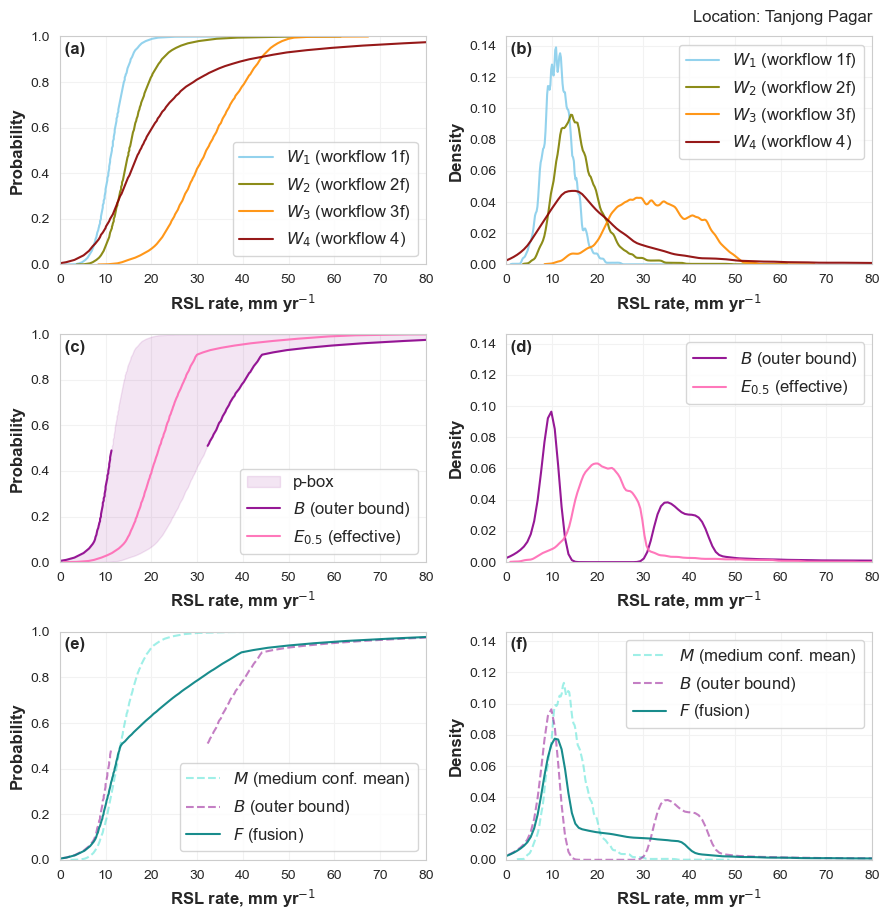

In [8]:
# Sea-level rise rate: SSP5 year-2100 AR6 projections, p-box, and fusion
fig, axs = d23a.fig_qfs_marginals(workflows_r=(('wf_1f', 'wf_2f', 'wf_3f', 'wf_4'), ('outer', 'effective_0.5'), ('fusion_1f+2f',)),
                                  bg_workflows_r=(list(), list(), ('mean_1f+2f', 'outer')),
                                  pbox_r=(False, True, False),
                                  rate=True, scenario='ssp585', year=2100, gauge='TANJONG_PAGAR', xlim=[0, 80])
d23a.name_save_fig(fig, fso='s')

Written s02.pdf (0.02 MB)
Written s02.png (0.13 MB)


's02'

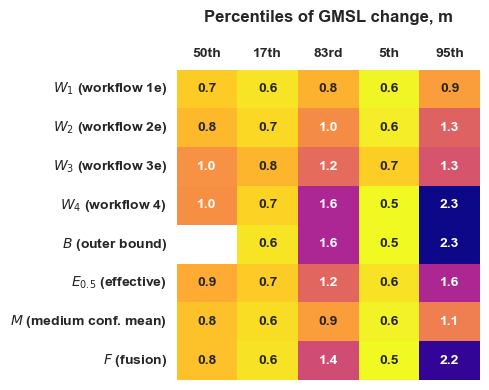

In [9]:
# Heatmap table of SSP5 year-2100 sea level percentiles
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
d23a.plot_percentiles_heatmap(percentiles=('50th', '17th', '83rd', '5th', '95th'),
                              workflows=('wf_1e', 'wf_2e', 'wf_3e', 'wf_4', 'outer', 'effective_0.5', 'mean_1e+2e', 'fusion_1e+2e'),
                              rate=False, scenario='ssp585', year=2100, gauge=None, fmt='.1f', ax=ax)
d23a.name_save_fig(fig, fso='s')

Written s03.pdf (0.03 MB)
Written s03.png (0.16 MB)


's03'

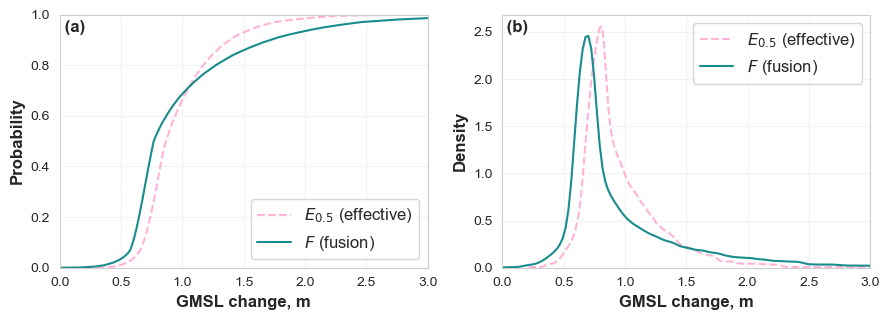

In [10]:
# SSP5 year-2100 effective_0.5 and fusion_1e+2e
fig, axs = d23a.fig_qfs_marginals(workflows_r=(('fusion_1e+2e',),),
                                  bg_workflows_r=(('effective_0.5',),),
                                  pbox_r=(False,),
                                  rate=False, scenario='ssp585', year=2100, gauge=None, xlim=(0, 3.))
d23a.name_save_fig(fig, fso='s')

## Other figures

Written o04.pdf (0.04 MB)
Written o04.png (0.36 MB)


'o04'

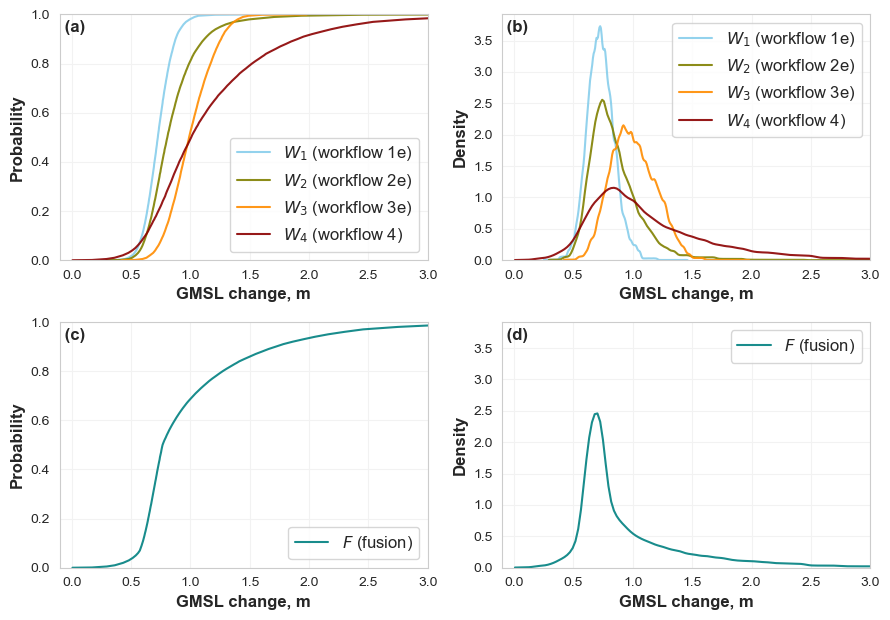

In [11]:
# SSP5 year-2100 AR6 projections and fusion
fig, axs = d23a.fig_qfs_marginals(workflows_r=(('wf_1e', 'wf_2e', 'wf_3e', 'wf_4'), ('fusion_1e+2e',)),
                                  bg_workflows_r=(list(), list()),
                                  pbox_r=(False, False),
                                  rate=False, scenario='ssp585', year=2100, gauge=None, xlim=(-0.1, 3.))
d23a.name_save_fig(fig, fso='o')

## Watermark and timing info

In [12]:
print(d23a.get_watermark())

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.13.2

matplotlib: 3.7.1
numpy     : 1.24.3
pandas    : 2.0.2
seaborn   : 0.12.2
xarray    : 2023.5.0

conda environment: d23a-fusion

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit


In [13]:
# Get end datetime
end_dt = datetime.datetime.now()
# Calculate run timedelta
run_td = end_dt - start_dt
# Print timing information
print(f"Start:     {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End:       {end_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Wall time: {run_td.seconds} s")

Start:     2024-01-16 15:38:27
End:       2024-01-16 15:39:06
Wall time: 39 s
